## 영상・이미지 데이터를 활용한 인공지능 기반 침수 위험 수준 탐지 기술 연구

Overview

<p align="center">
<img src="image/Original_image.png" width = 850 height = 750 alt=error></img>
</p>

수행 순서
1. 사용자의 ROI 지정
    - 기준점 (1개)
    - water segmentation 기준점 (1개)
    - 물 웅덩이 드래그 (2개)
    - 도로 폭 (3쌍)
2. YOLO 실행
    - 기준객체 탐지
    - 자동차 탐지
3. SAM 실행 (water segmentation)
4. Module #2 기준점 기반 침수 레벨 추정
5. Module #3 웅덩이 기반 침수 레벨 추정
6. Module #4 자동차 기반 침수 레벨 추정
7. Module #5 Module#2, 3, 4 추정 레벨 output Ensemble

# Module #1. 사용자의 ROI 지정

<p align="center">
<img src="image/module1_ROI.png" width = 500 height = 250 alt=error></img>
</p>

라이브러리 import

In [1]:
import numpy as np
import cv2
import subprocess
import torch
from PIL import Image
import os
from scipy.stats import hmean
import sys
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import VGG

이미지 로드 및 location(폴더명) 지정

In [2]:
video_name = "동래구_삼환맨션_앞^20230711-150000-20230711-160000"
video_path = "Dataset/test_case/" + video_name + ".avi" 
target_sec = [0, 46*60]
extracted_frame = []
video_save_name = "dongraegu_samhwanmension"

# 비디오 파일 열기
cap = cv2.VideoCapture(video_path)

# FPS와 총 프레임 수 가져오기
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_length_sec = total_frames / fps

for i in target_sec:
    # 지정한 초가 비디오 길이보다 길면 오류 메시지 출력
    if i > video_length_sec:
        print(f"Error: 지정한 초({i})가 영상 길이({video_length_sec:.2f}초)를 초과합니다.")
    else:
        # 초를 프레임으로 변환
        target_frame = int(i * fps)

        # 해당 프레임으로 이동하여 프레임 읽기
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
        ret, frame = cap.read()
        
        if ret:
            extracted_frame.append(frame)  # 추출된 프레임을 변수에 저장
            print(f"{i}초에 해당하는 프레임이 추출되었습니다.")
            os.makedirs('example/' + video_save_name + '/', exist_ok=True)
            cv2.imwrite('example/' + video_save_name + '/' + str(i)+ '.jpg', frame)
        else:
            print("Error: 프레임을 읽는 데 실패했습니다.")

# 자원 해제
cap.release()

# 확인
if 'extracted_frame' in locals():
    print(f"프레임이 변수 'extracted_frame'에 저장되었습니다.")


0초에 해당하는 프레임이 추출되었습니다.
2760초에 해당하는 프레임이 추출되었습니다.
프레임이 변수 'extracted_frame'에 저장되었습니다.


Text(0.5, 1.0, 'Image 1 Plotted')

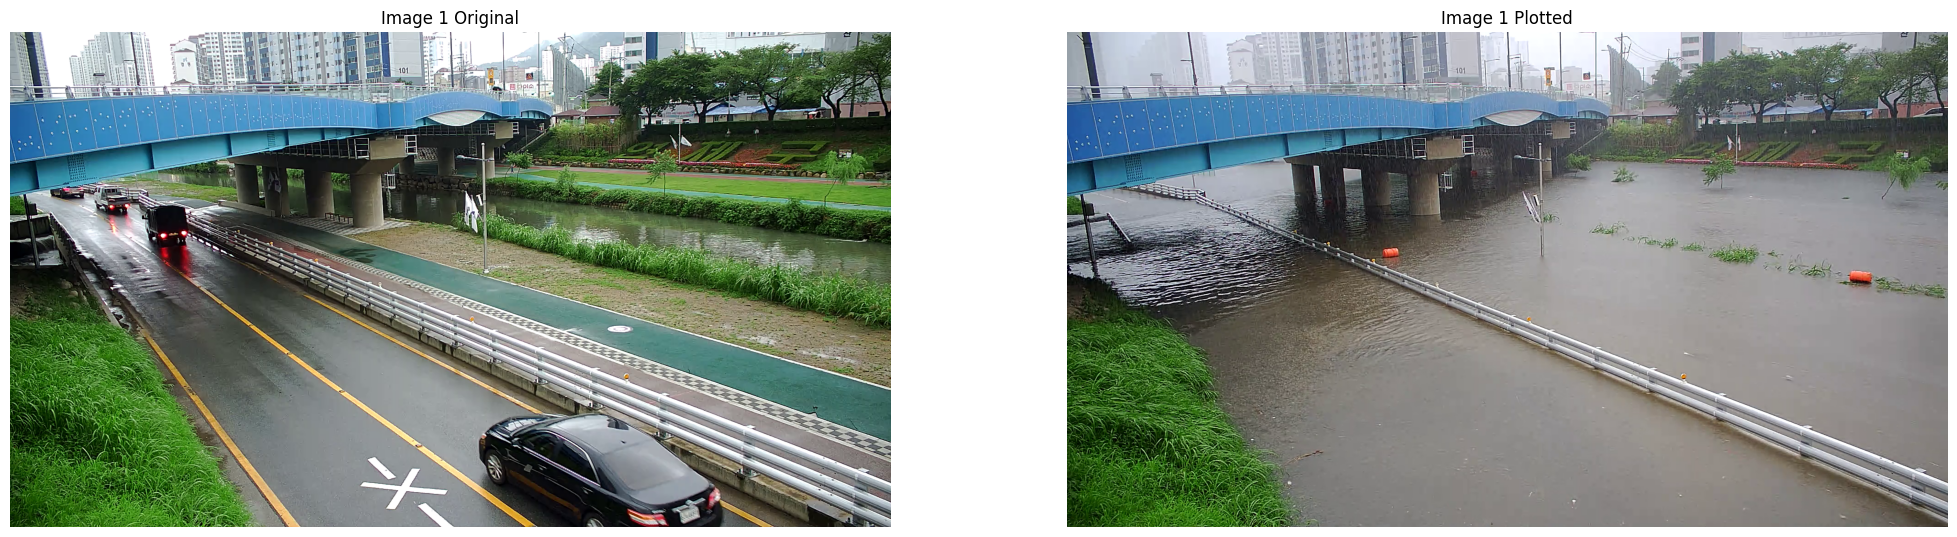

In [3]:

fig, axes = plt.subplots(1, 2, figsize=(25, 25))

axes[0].imshow(cv2.cvtColor(extracted_frame[0], cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title('Image 1 Original')

axes[1].imshow(cv2.cvtColor(extracted_frame[1], cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title('Image 1 Plotted')



In [4]:
location = video_name
road_real_distance = 300 # 도로의 폭은 300cm 로 지정 / 만일 다른 기준객체를 참고하려면 해당 기준객체의 실 cm 값으로 변경
lamp_real_distance = 400
pier_real_distance = 200

# s = 1 # 침수 전 이미지 프레임의 순서
# f = 4 # 침수 후 이미지 프레임의 순서

# image frame 불러오기
img_1 = extracted_frame[0]
img_n = extracted_frame[1]
img_1_org = img_1.copy()
img_n_org = img_n.copy()
img_1_copy = img_1.copy()

error_image = cv2.imread('example/error_image.png', cv2.IMREAD_COLOR)

img_height, img_width = img_n_org.shape[:2]

std_cor = [] # 기준점 좌표
seg_cor_1 = [] # 첫 프레임의 segment point 좌표
seg_cor_2 = [] # 두번째 프레임의 segment point 좌표
ROI_cor = [] # 물 웅덩이 roi 좌표들
# car_result = [1.5] # 자동차 환산비율 평균 (임의)
# obj_result = [1.5] # 탐지 물체 환산비율 평균 (임의)

기준점 선택 함수 정의

In [5]:
def click_event_seg(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # print(f"Clicked at x={x}, y={y}")
        cv2.putText(img_1, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),  2, cv2.LINE_AA)
        cv2.circle(img_1, (x, y), 8, (255, 0, 0), -1)  
        cv2.imshow('image', img_1)
        seg_cor_1.append(x)
        seg_cor_1.append(y)

def click_event_seg_2(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # print(f"Clicked at x={x}, y={y}")
        cv2.putText(img_1, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),  2, cv2.LINE_AA)
        cv2.circle(img_1, (x, y), 8, (255, 0, 0), -1)  
        cv2.imshow('image', img_1)
        seg_cor_2.append(x)
        seg_cor_2.append(y)

def click_event_std(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # print(f"Clicked at {x}, {y}, for std.")
        cv2.putText(img_1, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),  2, cv2.LINE_AA)
        cv2.circle(img_1, (x, y), 8, (255, 0, 0), -1)
        cv2.imshow('image', img_1)
        std_cor.append(x)
        std_cor.append(y)

drawing = False  # 드래그 상태를 확인하는 플래그
# 마우스 콜백 함수
def draw_rectangle(event, x, y, flags, param):
    global drawing, water_start_x, water_start_y, water_width, water_height, water_final_x, water_final_y, img_1_copy
    # print("start1")
    # 마우스 왼쪽 버튼을 누른 경우
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        water_start_x = x
        water_start_y = y

    # 마우스를 움직이는 중이고, 드래그 상태인 경우
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_1_copy = img_1.copy()
            cv2.rectangle(img_1_copy, (water_start_x, water_start_y), (x, y), (0, 255, 0), 5)
            cv2.imshow('image', img_1_copy)

    # 마우스 왼쪽 버튼을 뗀 경우
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        water_final_x = min(water_start_x, x)
        water_final_y = min(water_start_y, y)
        water_width = abs(water_start_x - x)
        water_height = abs(water_start_y - y)

        # 네 꼭짓점 좌표 계산
        top_left = (water_final_x, water_final_y)
        top_right = (water_final_x + water_width, water_final_y)
        bottom_left = (water_final_x, water_final_y + water_height)
        bottom_right = (water_final_x + water_width, water_final_y + water_height)

        # 네 꼭짓점 좌표 출력
        ROI_cor.append(top_left)
        ROI_cor.append(top_right)
        ROI_cor.append(bottom_left)
        ROI_cor.append(bottom_right)
        # print(f"Top-left: {top_left}")
        # print(f"Top-right: {top_right}")
        # print(f"Bottom-left: {bottom_left}")
        # print(f"Bottom-right: {bottom_right}")
        # print("1")

def draw_rectangle2(event, x, y, flags, param):
    global drawing, water_start_x, water_start_y, water_width, water_height, water_final_x, water_final_y, img_1_copy, img_1_copy2

    # 마우스 왼쪽 버튼을 누른 경우
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        water_start_x = x
        water_start_y = y

    # 마우스를 움직이는 중이고, 드래그 상태인 경우
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_1_copy2 = img_1_copy.copy()
            cv2.rectangle(img_1_copy2, (water_start_x, water_start_y), (x, y), (0, 255, 0), 5)
            cv2.imshow('image', img_1_copy2)

    # 마우스 왼쪽 버튼을 뗀 경우
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        water_final_x = min(water_start_x, x)
        water_final_y = min(water_start_y, y)
        water_width = abs(water_start_x - x)
        water_height = abs(water_start_y - y)

        # 네 꼭짓점 좌표 계산
        top_left = (water_final_x, water_final_y)
        top_right = (water_final_x + water_width, water_final_y)
        bottom_left = (water_final_x, water_final_y + water_height)
        bottom_right = (water_final_x + water_width, water_final_y + water_height)

        # 네 꼭짓점 좌표 출력
        ROI_cor.append(top_left)
        ROI_cor.append(top_right)
        ROI_cor.append(bottom_left)
        ROI_cor.append(bottom_right)
        # print(f"Top-left: {top_left}")
        # print(f"Top-right: {top_right}")
        # print(f"Bottom-left: {bottom_left}")
        # print(f"Bottom-right: {bottom_right}")
        # print("")

points = []  # 도로폭 픽셀 배열
distances = []  # 도로폭의 L2 거리
def draw_point_road(event, x, y, flags, param):
    global road_ratio_har_result
    
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(img_1_copy2, (x, y), 8, (0, 0, 255), -1)
        cv2.imshow('image', img_1_copy2)
        
        # 점이 적어도 두 개 이상일 때, 마지막으로 추가된 두 점의 거리를 계산하고 표시
        if len(points) % 2 == 0:
            pt1 = np.array(points[-2])
            pt2 = np.array(points[-1])
            
            distance = np.linalg.norm(pt2 - pt1)  
            distances.append(distance)
            
            # 거리를 이미지에 표시
            mid_x = (pt1[0] + pt2[0]) // 2
            mid_y = (pt1[1] + pt2[1]) // 2
            # 거리와 선을 img_n에 표시
            cv2.putText(img_1_copy2, f'{distance:.2f} px', (mid_x, mid_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.line(img_1_copy2, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0, 0, 255), 2)

            cv2.imshow('image', img_1_copy2)

            if len(distances) % 3 == 0:  # 세 쌍의 점이 찍힌 경우
                # 도로 폭의 조화평균 구하기 (h_mean_distance)
                h_mean_distance = hmean(distances)
                road_ratio_har_result = road_real_distance / h_mean_distance  # 조화 평균 계산 후 환산 비율 계산
                # print(f"환산 비율: {road_ratio_har_result:.2f} cm/px")
def convert_and_put_text(org_image, text, num): # 원본 이미지 / 입력할 텍스트 / 작동 순서 입력
    image_convert = org_image
    image_pil = Image.fromarray(image_convert)
    draw = ImageDraw.Draw(image_pil)
    draw.text(((img_width-50)/5, (img_height - 140)),  text , font=ImageFont.truetype("./font/NanumSquareB.ttf", 50), fill=(255,255,255))
    image_convert_2_numpy = np.array(image_pil)
    # return cv2.cvtColor(image_convert_2_numpy, cv2.COLOR_RGB2BGR)
    return image_convert_2_numpy

사용자의 기준점 선정
> 클릭 후 키보드(어떤 값이던 상관없음)를 누르거나 "X" 를 눌러 창을 꺼야 다음 ROI 선택 가능

In [6]:
# 기준점 1개 클릭
cv2.imshow('image', convert_and_put_text(img_1, "1. 기준점 1개 클릭 후 키보드 아무 키나 누르세요", 1))
cv2.setMouseCallback('image', click_event_std)
cv2.waitKey(0)
cv2.imwrite('exam_img/image1.jpg', convert_and_put_text(img_1, "1. 기준점 1개 클릭 후 키보드 아무 키나 누르세요", 1))


# water segmentation 기준점 1개 클릭
cv2.imshow('image', convert_and_put_text(img_1, "2. water segmentation 기준점 1개 클릭 후 키보드 아무 키나 누르세요", 2))
cv2.setMouseCallback('image', click_event_seg_2)
cv2.waitKey(0)
cv2.imwrite('exam_img/image2.jpg', convert_and_put_text(img_1, "2. water segmentation 기준점 1개 클릭 후 키보드 아무 키나 누르세요", 2))


cv2.imshow('image', convert_and_put_text(img_n, "3. water segmentation 기준점 1개 클릭 후 키보드 아무 키나 누르세요", 3))
cv2.setMouseCallback('image', click_event_seg)
cv2.waitKey(0)
cv2.imwrite('exam_img/image2_2.jpg', convert_and_put_text(img_n, "3. water segmentation 기준점 1개 클릭 후 키보드 아무 키나 누르세요", 3))

# 웅덩이 드래그 1 

cv2.imshow('image', convert_and_put_text(img_1, "4. 첫번째 물 웅덩이 드래그 후 키보드 아무 키나 누르세요", 4))
cv2.setMouseCallback('image', draw_rectangle)
cv2.waitKey(0)


# 웅덩이 드래그 2

cv2.imshow('image', convert_and_put_text(img_1_copy, "5. 두번째 물 웅덩이 드래그 후 키보드 아무 키나 누르세요", 5))
cv2.setMouseCallback('image', draw_rectangle2)
cv2.waitKey(0)
cv2.imwrite('exam_img/image3.jpg',convert_and_put_text(img_1_copy, "5. 첫번째 물 웅덩이 드래그 후 키보드 아무 키나 누르세요", 5))
cv2.imwrite('exam_img/image4.jpg',convert_and_put_text(img_1_copy, "5. 두번째 물 웅덩이 드래그 후 키보드 아무 키나 누르세요", 5))

#도로 폭 3쌍의 점 클릭

cv2.imshow('image', convert_and_put_text(img_1_copy2, "6. 도로 폭 총 3쌍의 점 클릭 후 키보드 아무 키나 누르세요", 6))
cv2.setMouseCallback('image', draw_point_road)
cv2.waitKey(0)
cv2.imwrite('exam_img/image5.jpg', convert_and_put_text(img_1_copy2, "6. 도로 폭 총 3쌍의 점 클릭 후 키보드 아무 키나 누르세요", 6))
cv2.imwrite('exam_img/image000.jpg', img_1_copy2)
cv2.destroyAllWindows()

### YOLO 실행

>  한번 실행 후 반드시 폴더 삭제할것 (덮어씌워짐)

<p align="center">
<img src="image/module1_SAM_YOLO.png" width = 500 height = 250 alt=error></img>
</p>

#### 기준객체 탐지

> Custom YOLOv6

c:\2024\Flooding\FloodEstimation


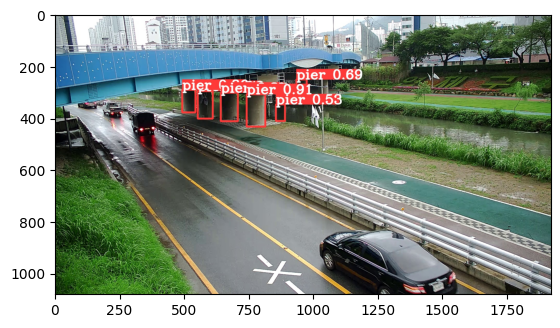

In [7]:
'''
YOLO로 기준객체 탐지 후 바운딩박스 생성

동작 과정
1. YOLO 로 첫번째 이미지 프레임에 있는 자동차 detect
2. 탐지 결과를 file_path 와 result_image_path 에 저장
3. 탐지 결과를 읽어들인 후, 조건에 맞는 객체 (자동차이며 신뢰도가 0.4 이상) 의 네 꼭짓점의 좌표 출력
4. 탐지 결과 이미지 보여줌
'''

# YOLO detection 관련 경로 설정
print(os.getcwd())
command = [
    './flood1212/Scripts/python.exe', './YOLOv6-main/tools/infer.py',
    '--weights', './finetuned_models/custom_best_1027.pt',
    '--source', f'./example/' + video_save_name + '/' + str(target_sec[0]) + '.jpg',
    '--yaml', './finetuned_models/dataset_custom_1027.yaml',
    '--device', '0',
    '--save-txt', 
    '--save-dir', f'./object_detection_results/others/' + video_save_name + '/'
]

subprocess.run(command)
print("==============")

# txt 파일이 존재하는지 확인하고 예외 처리
if os.path.exists(f'object_detection_results/others/{video_save_name}/{target_sec[0]}.jpg'):
    # 탐지된 결과를 보여주기
    obj_detected_img = cv2.imread(f'object_detection_results/others/{video_save_name}/{target_sec[0]}.jpg', cv2.IMREAD_COLOR)
    obj_detected_img = cv2.cvtColor(obj_detected_img, cv2.COLOR_BGR2RGB)

    # cv2.imshow('Detected Cars', detected_img)
    # cv2.waitKey(0)  # 키 입력을 기다림
    # cv2.destroyAllWindows()


    plt.imshow(obj_detected_img)
    plt.show()
else:
    print("탐지된 기준객체가 없습니다.")
    obj_detected_img=None



#### 자동차 탐지

> COCO pre-trained YOLOv6lv

In [8]:
'''
YOLO로 자동차 탐지 후 바운딩박스 생성

변수
unique_boxes: 바운딩 박스 좌표를 중복 저장하지 않기 위해 사용하는 set
class_id: 자동차의 class_id = 6
corners: YOLO 로 탐지한 bounding box의, 네 꼭짓점의 좌표

동작 과정
1. YOLO 로 첫번째 이미지 프레임에 있는 자동차 detect
2. 탐지 결과를 file_path 와 result_image_path 에 저장
3. 탐지 결과를 읽어들인 후, 조건에 맞는 객체 (자동차이며 신뢰도가 0.4 이상) 의 네 꼭짓점의 좌표 출력
4. 탐지 결과 이미지 보여줌
'''

# YOLO detection 관련 경로 설정
print(os.getcwd())
command = [
    './flood1212/Scripts/python.exe', './YOLOv6-main/tools/infer.py',
    '--weights', './YOLOv6-main/runs/yolov6l6.pt',
    '--source', f'./example/' + video_save_name + '/' + str(target_sec[1]) + '.jpg',
    '--yaml', './YOLOv6-main/data/coco.yaml',
    '--device', '0',
    '--save-txt', 
    '--save-dir', f'./object_detection_results/cars/' + video_save_name + '/'
]

subprocess.run(command)
print("==============")

file_path = f'./object_detection_results/cars/{video_save_name}/labels/{target_sec[1]}.txt'
result_image_path = f'./object_detection_results/cars/{video_save_name}/{target_sec[1]}.jpg'
result = []


# txt 파일이 존재하는지 확인하고 예외 처리
if os.path.exists(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            elements = line.strip().split()
            int_elements = list(map(float, elements))
            result.append(int_elements)
else:
    print("탐지된 차량이 없습니다.")
    result = []
    car_detected_img = None

img_height, img_width = img_n_org.shape[:2]
cropped_car_images = []
if len(result) != 0:
    # 중복된 바운딩 박스 좌표를 저장하지 않도록 set 사용
    unique_boxes = set()

    # 바운딩 박스의 좌표 계산 및 출력
    for line in result:
        class_id = line[0]
        confidence = line[5]
        if class_id == 2 and confidence >= 0.55:
            # YOLO 형식: class, x_center, y_center, width, height, confidence
            x_center, y_center, width, height = line[1:5]

            # 이미지 좌표계로 변환
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            # 바운딩 박스 좌표 (x_min, y_min, x_max, y_max)
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)

            # 네 꼭짓점 좌표
            corners = ((x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max))

            # 중복되지 않은 바운딩 박스 좌표만 추가
            if corners not in unique_boxes:
                unique_boxes.add(corners)
                # 좌표 출력
                print(f"Car detected with bounding box corners: {corners}")

                # 바운딩 박스 영역을 이미지에서 크롭
                cropped_img = img_n_org[y_min:y_max, x_min:x_max]
                
                # 크롭된 이미지 저장
                cropped_car_images.append(cropped_img)

    # 탐지된 결과를 보여주기
    car_detected_img = cv2.imread(f'object_detection_results/cars/{video_save_name}/{target_sec[1]}.jpg', cv2.IMREAD_COLOR)
    detected_img = cv2.cvtColor(car_detected_img, cv2.COLOR_BGR2RGB)
    # cv2.imshow('Detected Cars', detected_img)
    # cv2.waitKey(0)  # 키 입력을 기다림
    # cv2.destroyAllWindows()


    plt.imshow(car_detected_img)
    plt.show()
    

c:\2024\Flooding\FloodEstimation
탐지된 차량이 없습니다.


### SAM

> model load

In [9]:
import torch
import sys
import os
# sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./finetuned_models/combined_model_1027.pth"

# 모델 유형 지점
model_type = "vit_h"

# 모델 인스턴스 생성
sam = sam_model_registry[model_type]()
# 크기가 맞지 않는 차원을 무시하고 state_dict를 로드하는 함수
def load_partial_state_dict (model, state_dict):
	model_state = model.state_dict()
	for name, param in state_dict.items():
		if name in model_state:
			if param.size() == model_state[name].size():
				model_state[name].copy_(param)
			else:
				print (f" {name}를 건너뜁니다: 모델은 {model_state[name].size()}를 기대하지만, 체크포인트는 {param.size()}를 제공합니다).")
	model.load_state_dict (model_state, strict=False)

# 체크포인트 로드, 모델 업데이트
checkpoint = torch.load(sam_checkpoint, map_location='cpu')
load_partial_state_dict (sam, checkpoint ['model']) 
sam.to(device='cuda')

# predictor 인스턴스 생성
predictor = SamPredictor (sam)

C:\Users\th_gu\AppData\Local\Temp\ipykernel_13832\505817236.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(sam_checkpoint, map_location='cpu')


 image_encoder.pos_embed를 건너뜁니다: 모델은 torch.Size([1, 64, 64, 1280])를 기대하지만, 체크포인트는 torch.Size([1, 64, 64, 768])를 제공합니다).


> water segmentation 수행 후 water mask 저장

In [10]:
input1 = img_1_org
input2 = img_n_org
image1 = cv2.cvtColor(input1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(input2, cv2.COLOR_BGR2RGB)
input_point = np.array([seg_cor_1])
input_point_2 = np.array([seg_cor_2])
input_label = np.array([1])


predictor.set_image(image1)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

img_1_mask = (masks[1] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환


predictor.set_image(image2)
masks, scores, logits = predictor.predict(
    point_coords=input_point_2,
    point_labels=input_label,
    multimask_output=True,
)
img_n_mask = (masks[1] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환

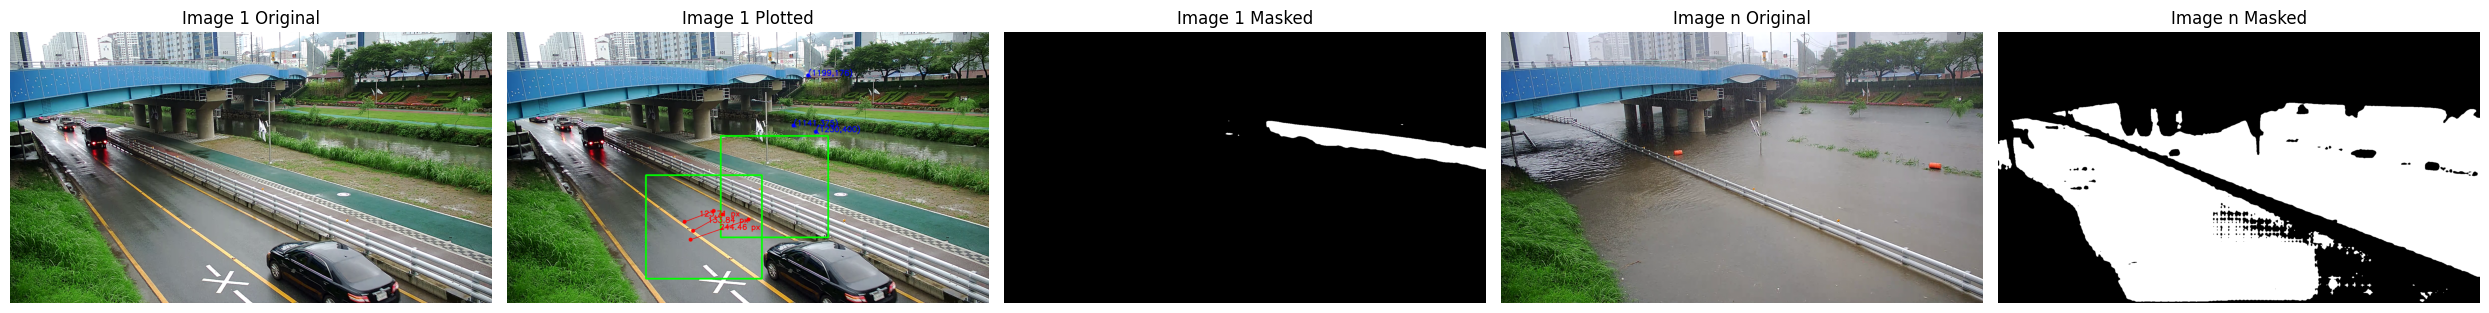

[1199, 176] [(851, 416), (1279, 416), (851, 819), (1279, 819), (553, 572), (1015, 572), (553, 983), (1015, 983)] 1.9645268090405872


In [11]:
img_1_org_show = cv2.cvtColor(img_1_org, cv2.COLOR_BGR2RGB)
img_n_org_show = cv2.cvtColor(img_n_org, cv2.COLOR_BGR2RGB)
img_1_copy2_show = cv2.cvtColor(img_1_copy2, cv2.COLOR_BGR2RGB)


fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes[0].imshow(img_1_org_show)
axes[0].axis('off')
axes[0].set_title('Image 1 Original')

axes[1].imshow(img_1_copy2_show)
axes[1].axis('off')
axes[1].set_title('Image 1 Plotted')

axes[2].imshow(img_1_mask, cmap = 'gray')
axes[2].axis('off')
axes[2].set_title('Image 1 Masked')

axes[3].imshow(img_n_org_show)
axes[3].axis('off')
axes[3].set_title('Image n Original')

axes[4].imshow(img_n_mask, cmap = 'gray')
axes[4].axis('off')
axes[4].set_title('Image n Masked')

plt.tight_layout()
plt.show()

print(std_cor, ROI_cor, road_ratio_har_result)

# Module #2. 기준점-based

<p align="center">
<img src="image/module2.png" width = 300 height = 300 alt=error></img>
</p>

<p align="center">
<img src="image/module1_point.png" width = 1000 height = 250 alt=error></img>
</p>

In [12]:
total_water_px_dis = []        # 물의 증가값 list (PX)
total_ratio_road = road_ratio_har_result    # 도로 폭 기반 비율값 list (cm/px)
total_ratio_obj = None     # yolo 로 탐지된 기준객체 전체 기준객체 비율 평균값 (cm/px)
total_obj_based_cm = []
total_road_based_cm = []
module2_results = []    # module #2 추정 침수 레벨 list (level)

> 기준객체 기반 비율 계산 (cm/px)

!!!!!!!!!! 신뢰도 0.5 이상으로 수정할 것!!!! (현재는 테스트를 위해 낮게 설정함)

In [13]:
# YOLO 사용한 기준객체 비율 계산
obj_ratio_result = []  # 각 사진 별 기준객체 픽셀 수 계산 리스트


# 위에서 YOLO detection 결과를 저장한 path
file_path = f'object_detection_results/others/{video_save_name}/labels/{target_sec[0]}.txt'

obj_detect_result = []


# YOLO detect 한 바운딩박스 값이 저장된 txt 파일 open
if os.path.isfile(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            # 각 줄의 양 끝 공백을 제거하고, 띄어쓰기를 기준으로 분할하여 리스트로 저장
            elements = line.strip().split()
            int_elements = list(map(float, elements))
            obj_detect_result.append(int_elements)

    # line 의 index 0: 기준객체의 클래스 number
    # line 의 index 5: 기준객체 탐지 신뢰도
    # line 의 index 4: 탐지된 기준객체의 height 값 (px)
    for line in obj_detect_result:
        # print(line)
        if line[0] == 0 and line[5] >= 0.3:  # 교각 and 신뢰도 0.3 이상의 detection만
            # 교각 평균 높이.................................... -> 2m
            obj_ratio_result.append( pier_real_distance / (img_height * line[4]))
        if line[0] == 1 and line[5] >= 0.3:  # 가로등 and 신뢰도 0.3 이상의 detection만
            # 가로등 평균 높이.................................... -> 4.m
            obj_ratio_result.append( lamp_real_distance / (img_height * line[4]))
        # if line[0] == 6 and line[5] >= 0.3:  # 자동차 and 신뢰도 0.3 이상의 detection만
        #     # 자동차 평균 높이.................................... -> 1.5m
        #     obj_ratio_result.append( 150 / (img_height * line[4]))
        # if line[0] == 7 and line[5] >= 0.3:  # 전봇대 and 신뢰도 0.3 이상의 detection만
        #     # 전봇대 평균 높이.................................... -> 14m
        #     obj_ratio_result.append( 1400 / (img_height * line[4]))
    # print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    # print(obj_ratio_result)
    print("obj_ratio_result:", obj_ratio_result)

    # yolo 로 탐지된 기준객체 기반 비율 계산 (cm/px)
    obj_ratio_result = np.array(obj_ratio_result)
    # total_ratio_obj.append(len(obj_ratio_result) / np.sum(1.0 / obj_ratio_result) if len(obj_ratio_result) > 0 else 0)  # 조화 평균 사용

    total_ratio_obj = np.mean(obj_ratio_result) # 평균내기
    print("total_ratio_obj: ", total_ratio_obj)

else:
    print("참고할 기준객체가 없습니다.")
    total_ratio_obj = 0



obj_ratio_result: [3.124997851563977, 3.174604988663168, 1.8867933784269404, 2.298849306381992, 1.8181791735575659, 1.5999964160080282, 3.124997851563977, 3.174604988663168, 1.8867933784269404, 2.298849306381992, 1.8181791735575659, 1.5999964160080282, 3.124997851563977, 3.174604988663168, 1.8867933784269404, 2.298849306381992, 1.8181791735575659, 1.5999964160080282, 3.124997851563977, 3.174604988663168, 1.8867933784269404, 2.298849306381992, 1.8181791735575659, 1.5999964160080282, 3.124997851563977, 3.174604988663168, 1.8867933784269404, 2.298849306381992, 1.8181791735575659, 1.5999964160080282, 3.124997851563977, 3.174604988663168, 1.8867933784269404, 2.298849306381992, 1.8181791735575659, 1.5999964160080282]
total_ratio_obj:  2.317236852433612


> 기준점과 water mask 간의 거리(px) 계산 함수

In [14]:
def find_white_point(img, x, y_start):
    """
    이미지에서 특정 x 좌표에 대해 y_start부터 내려가며 흰색(255) 부분을 찾는 함수
    img: 이미지 (numpy 배열)
    x: 수직선을 그릴 x 좌표
    y_start: 검색을 시작할 y 좌표
    return: 처음으로 흰색(255) 부분과 만나는 (x, y) 좌표
    """
    height = img.shape[0]  # 이미지의 세로 길이 (y 축의 최대 값)

    # y_start부터 이미지의 끝까지 내려가면서 흰색 부분(255)이 있는지 확인
    for y in range(y_start, height):
        if img[y, x] == 255:  # 흰색 부분을 만나면
            return (x, y)

    # 흰색 부분을 만나지 못하면 None 리턴
    return (300000, 300000)

### 기준점 (1개) 기반 침수 높이 추정

#### 사용자 지정 기준점(1개) 기반 침수 레벨 추정

In [15]:
# std_cor 리스트에 있는 각 좌표에 대해 img1과 img2에서 흰색 좌표를 찾기
point_img1 = []
point_img2 = []


x, y_start = std_cor  # std_cor에서 x와 시작 y 좌표를 추출
print(x, y_start)

# img1에서 흰색 부분 찾기
point1 = find_white_point(img_1_mask, x, y_start)
if point1:
    point_img1.append(point1[0])
    point_img1.append(point1[1])

# img2에서 흰색 부분 찾기
point2 = find_white_point(img_n_mask, x, y_start)
if point2:
    point_img2.append(point2[0])
    point_img2.append(point2[1])

# 결과: point_img1, point_img2 에 각각 흰색 좌표들이 저장됨
print("mask 1 에서 물과 맞닿는 좌표:", point_img1)
print("mask n 에서 물과 맞닿는 좌표:", point_img2)
if point2==None or point1==None or point_img1[0]==300000 or point_img2[0]==300000:
    print("물의 증가 픽셀 구할 수 없음")
    total_water_px_dis.append(300000)
    
else:
    # mask 에서 물의 증가 거리 구하기 (px)
    total_water_px_dis.append(point_img1[1]-point_img2[1])
    print("물의 증가 px:", total_water_px_dis[0])

1199 176
mask 1 에서 물과 맞닿는 좌표: [1199, 375]
mask n 에서 물과 맞닿는 좌표: [1199, 287]
물의 증가 px: 88


### 침수 속도 추정

In [16]:
target_sec
flood_speed = []
if total_water_px_dis[0] == 30000:
    print("침수 속도 추정 불가")
elif total_ratio_obj != 0 or total_ratio_road != 0:
    # 물 영역 증가 px 과 기준객체 기반 환산비율 곱하기
    flood_speed.append(total_water_px_dis[0]*total_ratio_obj)
    # 물 영역 증가 px 과 도로 폭 기반 환산비율 곱하기
    flood_speed.append(total_water_px_dis[0]*total_ratio_road)

total_flood_speed =  ( ( flood_speed[0] * 1 + flood_speed[1] * 2 ) / 3 ) / (target_sec[1] - target_sec[0])

print(f"침수 속도 {round(total_flood_speed, 3)}(cm/sec)")

침수 속도 0.066(cm/sec)


> 코드 완성되면 삭제할 것

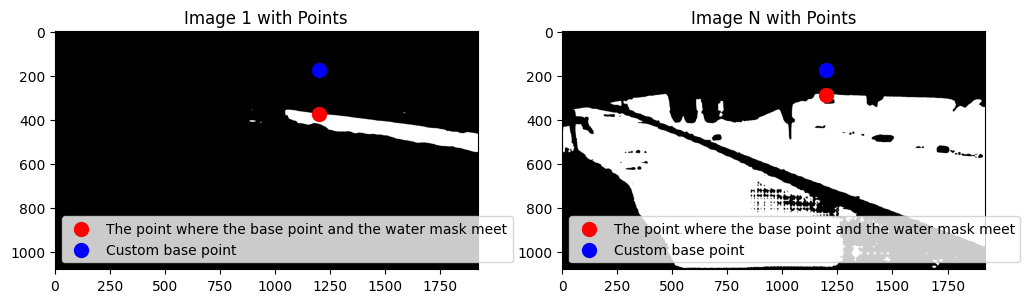

In [17]:
if point2==None or point1==None:
    print("X")
else:
    # 이미지 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # 첫 번째 이미지 시각화
    ax[0].imshow(img_1_mask, cmap='gray')
    ax[0].scatter(point_img1[0], point_img1[1], color='red', label='The point where the base point and the water mask meet', s=100)
    ax[0].scatter(x, y_start, color='blue', label='Custom base point', s=100)
    ax[0].set_title('Image 1 with Points')
    ax[0].legend()

    # 두 번째 이미지 시각화
    ax[1].imshow(img_n_mask, cmap='gray')
    ax[1].scatter(point_img2[0], point_img2[1], color='red', label='The point where the base point and the water mask meet', s=100)
    ax[1].scatter(x, y_start, color='blue', label='Custom base point', s=100)
    ax[1].set_title('Image N with Points')
    ax[1].legend()

    plt.show()

### 사용자 지정 기준점(1개) + 그 주변 점(2개) 기반 침수 레벨 추정

In [18]:
# 직접 찍은 기준점과 그 근처 점(2개) -  물 사이의 거리 구하기

# std_cor 리스트에 있는 각 좌표에 대해 img1과 img2에서 흰색 좌표를 찾기
point_img1 = []
point_img2 = []


x, y_start = std_cor  # std_cor에서 x와 시작 y 좌표를 추출
print(x, y_start)

for i in range(3):
    # img1에서 흰색 부분 찾기
    point1 = find_white_point(img_1_mask, x, y_start)
    if point1:
        # point_img1.append(point1[0])
        point_img1.append(point1[1])

    # img2에서 흰색 부분 찾기
    point2 = find_white_point(img_n_mask, x, y_start)
    if point2:
        # point_img2.append(point2[0])
        point_img2.append(point2[1])
    x += 60


# 결과: point_img1, point_img2 에 각각 흰색 좌표들이 저장됨
print("mask 1 에서 물과 맞닿는 좌표:", point_img1)
print("mask n 에서 물과 맞닿는 좌표:", point_img2)



1199 176
mask 1 에서 물과 맞닿는 좌표: [375, 381, 387]
mask n 에서 물과 맞닿는 좌표: [287, 290, 291]


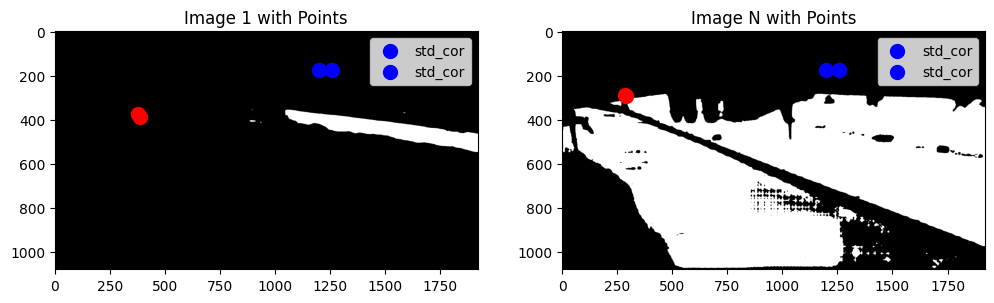

In [19]:
if point2==None or point1==None:
    print("X")
    
else:
    # 이미지 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # 첫 번째 이미지 시각화
    ax[0].imshow(img_1_mask, cmap='gray')

    x = std_cor[0]
    # point_img1 시각화
    for i in range(0, len(point_img1), 2):  # 2씩 증가하며 점을 묶어 시각화
        ax[0].scatter(point_img1[i], point_img1[i], color='red', s=100)
        # std_cor 시각화 (이동한 위치)
        ax[0].scatter(x, std_cor[1] , color='blue', label='std_cor', s=100)
        x += 60
    ax[0].set_title('Image 1 with Points')
    ax[0].legend()

    # 두 번째 이미지 시각화
    ax[1].imshow(img_n_mask, cmap='gray')

    x = std_cor[0]
    # point_img2 시각화
    for i in range(0, len(point_img2), 2):  # 2씩 증가하며 점을 묶어 시각화
        ax[1].scatter(point_img2[i], point_img2[i], color='red', s=100)
        # std_cor 시각화 (이동한 위치)
        ax[1].scatter(x, std_cor[1], color='blue', label='std_cor', s=100)
        x += 60
    ax[1].set_title('Image N with Points')
    ax[1].legend()

    plt.show()

In [20]:
from statistics import mean
point_water_dis=[]
# three_point_road = []
# three_point_obj = []

if point2==None or point1==None:
    print("X")
    total_water_px_dis.append(300000)
else:
    for i in range(len(point_img1)):
        if point_img1[i] != 300000 and  point_img2[i] != 300000:
            # mask 에서 물의 증가 거리 구하기 (px)
            point_water_dis.append(point_img1[i]-point_img2[i])
        else:
            print(f"기준점 {i}번째 점 물의 증가값 구할 수 없음")

if len(point_water_dis) != 0:
    print(f"기준점 {len(point_water_dis)}개 기반 물의 증가 px:", point_water_dis)
    # print("도로 폭 기반 침수 깊이 (cm): ", mean(three_point_road))
    # print("기준객체 기반 침수 깊이 (cm): ", mean(three_point_obj))
    print(f"기준점 {len(point_water_dis)}개 기반 물의 증가 px 평균값:", mean(point_water_dis))
    total_water_px_dis.append(mean(point_water_dis))
    # 가중치 계산
    # 도로 폭 가중치: 3
    # 기준객체 가중치: 1
    # module2_results.append((mean(three_point_road) * 3 + mean(three_point_obj)* 1 ) / 4)
    # print(module2_results)

기준점 3개 기반 물의 증가 px: [88, 91, 96]
기준점 3개 기반 물의 증가 px 평균값: 91.66666666666667


In [21]:
total_water_px_dis

[88, 91.66666666666667]

### 마스크 전체 조화평균 기반 침수 레벨 추정

In [22]:
# 이미지 경로 확인 및 로드
img_1_array = np.array(img_1_mask)
img_n_array = np.array(img_n_mask)

mask_height, mask_width, = img_1_array.shape
height = []
x_array = []

# 침수 비교 영역 설정
for x in range(mask_width):
    for y in range(mask_height):
        if img_n_array[y, x] > 200:  # 침수 후 영역의 x 값이
            if img_1_array[y, x] > 200:  # 침수 전 영역의 x 값에도 있다면
                x_array.append(x)  # 올바른 침수 비교 영역으로 설정
                break

print(f"Valid X coordinates count: {len(x_array)}")

# y 값의 증가 값 계산
for x in x_array:
    for y in range(mask_height):
        if img_1_array[y, x] > 200:
            a = y  # 침수 비교 영역의 x값에 대한 가장 높은 침수 전 영역의 y 값
            break
    for y in range(mask_height):
        if img_n_array[y, x] > 200:
            b = y  # 침수 비교 영역의 x값에 대한 가장 높은 침수 후 영역의 y 값
            break
    height.append(a - b)  # y 값의 증가 값

height = np.array(height)

# 조화 평균 계산
if len(height) > 0 and np.sum(height > 0) > 0:  # 0으로 나누는 경우 방지
    harmonic_height_mask = len(height) / np.sum(1.0 / height[height > 0])
    print(f"Mask's Harmonic Flood Height(px): {harmonic_height_mask}")
    total_water_px_dis.append(harmonic_height_mask)
else:
    harmonic_height_mask = 0
    print("No valid height data for harmonic mean calculation.")
    total_water_px_dis.append(300000)



Valid X coordinates count: 910
Mask's Harmonic Flood Height(px): 71.07776659455737


In [23]:
total_water_px_dis

[88, 91.66666666666667, 71.07776659455737]

> mask 시각화

In [24]:
def mask_add(image, mask, color):
    # mask 이미지를 지정한 색으로으로 변환하고, 검정색 부분을 투명하게 만든다
    purple_mask = np.zeros_like(image)
    purple_mask[mask > 0] = color

    # 알파 채널 추가 (투명도 설정)
    alpha_channel = np.zeros_like(mask)
    alpha_channel[mask > 0] = 255
    purple_mask = cv2.merge((*cv2.split(purple_mask), alpha_channel))

    # 원본 이미지에도 알파 채널 추가
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

    # 두 이미지를 합친다
    composited_image = cv2.addWeighted(original_image, 1, purple_mask, 1, 0)
    return composited_image

In [25]:
total_water_px_dis

[88, 91.66666666666667, 71.07776659455737]

In [26]:
total_ratio_obj

2.317236852433612

In [27]:
for i in range(len(total_water_px_dis)):
    if total_water_px_dis[i] != 300000 and total_water_px_dis[i] > 0:
        if i < 2:
            print(f"기준점 {i*2+1}개 기반 물 증가 픽셀값: {total_water_px_dis[i]} PX")
            total_obj_based_cm.append(total_water_px_dis[i]*total_ratio_obj)
            total_road_based_cm.append(total_water_px_dis[i]*total_ratio_road)
        else:
            print(f"마스크 조화평균 기반 물 증가 픽셀값: {total_water_px_dis[i]} PX")
            total_obj_based_cm.append(total_water_px_dis[i]*total_ratio_obj)
            total_road_based_cm.append(total_water_px_dis[i]*total_ratio_road)

    else:
        if i == 2:
            print("마스크 조화평균 기반 침수 추정 불가능")
        else:
            print(f"기준점 {i*2 + 1}개 기반 침수 추정 불가능")
            

print("total_water_px_dis", total_water_px_dis)
print("total_ratio_obj", total_ratio_obj)
print("total_ratio_road", total_ratio_road)
print("total_obj_based_cm", total_obj_based_cm)
print("total_road_based_cm", total_road_based_cm)


    # # 가중치 계산
    # # 도로 폭 가중치: 3
    # # 기준객체 가중치: 1
    # module2_results.append((har_total[0] * 3 + har_total[1]* 1 ) / 4)
    # print(module2_results)


if total_ratio_obj == 0:    # 기준객체 없는 경우
    module2_results = total_road_based_cm
    print(module2_results)
else:
    module2_results = [(road * 3 + obj * 1) / 4 for road, obj in zip(total_road_based_cm, total_obj_based_cm)]
    print(module2_results)



기준점 1개 기반 물 증가 픽셀값: 88 PX
기준점 3개 기반 물 증가 픽셀값: 91.66666666666667 PX
마스크 조화평균 기반 물 증가 픽셀값: 71.07776659455737 PX
total_water_px_dis [88, 91.66666666666667, 71.07776659455737]
total_ratio_obj 2.317236852433612
total_ratio_road 1.9645268090405872
total_obj_based_cm [203.91684301415785, 212.41337813974778, 164.70402014158307]
total_road_based_cm [172.87835919557168, 180.08162416205383, 139.63417800173744]
[180.63798015021823, 188.16456265647733, 145.90163853669884]


### 침수 속도 추정

In [28]:
flood_speed = module2_results[0] / (target_sec[1]-target_sec[0])
print(f"침수 속도 추정 결과: {np.round(flood_speed, 3)} cm/sec")

침수 속도 추정 결과: 0.065 cm/sec


In [29]:
module2_results_level = []
if len(module2_results) == 0:
    print("침수 레벨 추정 불가")

else:
    # 계산된 값(cm) 에 대한 레벨 산정하는 코드

    # cm -> level 변환 (임의)
    # 0 -> level 0
    # 1 ~ 50 -> level 1
    # 51 ~ 100 -> level 2
    # 101 ~ 200 -> level 3
    # 201 ~ -> level 4
    for i in range(len(module2_results)):
        if module2_results[i] == 0:
            module2_results_level.append(0)
        elif 1 <= module2_results[i] <= 50:
            module2_results_level.append(1)
        elif 51 <= module2_results[i] <= 100:
            module2_results_level.append(2)
        elif 101 <= module2_results[i] <= 200:
            module2_results_level.append(3)
        elif 201 <= module2_results[i]:
            module2_results_level.append(4)

    # 각 방법 별 가중치 두기 위해 순서 바꿈
    module2_results_level.reverse()

    print("Module#2 기준점-based 결과")
    print("침수 추정 레벨: ", module2_results_level)

Module#2 기준점-based 결과
침수 추정 레벨:  [3, 3, 3]


# Module#3 웅덩이-based

<p align="center">
<img src="image/module3.png" width = 300 height = 300 alt=error></img>
</p>

In [30]:
module3_results_level = []

level: 2
level: 2


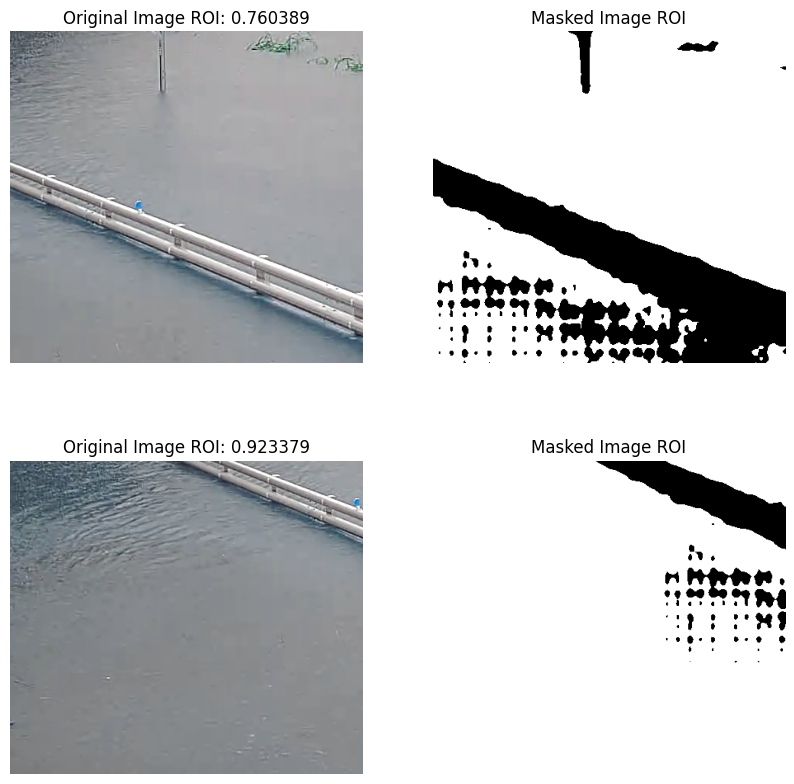

[2, 2]
[2, 2, 2]


In [31]:
img_n_mask = (masks[1] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    roi = img_n_mask[ROI_cor[(i*4+0)][1]:ROI_cor[(i*4+2)][1], ROI_cor[(i*4+0)][0]:ROI_cor[(i*4+1)][0]]
    roi_ori = img_n_org[ROI_cor[(i*4+0)][1]:ROI_cor[(i*4+2)][1], ROI_cor[(i*4+0)][0]:ROI_cor[(i*4+1)][0]]
    percentage = (np.sum(roi)/255)/((ROI_cor[i*4][0]-ROI_cor[i*4+1][0])*(ROI_cor[i*4][1]-ROI_cor[i*4+2][1]))
    axes[i][0].imshow(roi_ori)
    axes[i][0].axis('off')
    axes[i][0].set_title(f'Original Image ROI: {percentage:f}')

    axes[i][1].imshow(roi, cmap='gray')
    axes[i][1].axis('off')
    axes[i][1].set_title('Masked Image ROI')


    
    if percentage > 0.5:
        print('level: 2')
        module3_results_level.append(2)
    elif percentage > 0:
        print('level: 1')
        module3_results_level.append(1)
    else:
        print('level: 0')
        module3_results_level.append(0)

plt.show()


print(module3_results_level)

# 첫 번째 값을 복사해서 두 번째 위치에 삽입
module3_results_level.insert(1, module3_results_level[0])
print(module3_results_level)


# Module#4. 자동차-based method

<p align="center">
<img src="image/module4.png" width = 300 height = 300 alt=error></img>
</p>

In [32]:
module4_results_level = []

In [33]:
# Device 설정 (GPU가 있으면 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리
preprocess = transforms.Compose([
    transforms.Resize((125, 125)),
    transforms.ToTensor()
])

# 이미지 배열 전처리
def preprocess_image(cropped_img):
    img_pil = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess(img_pil)
    img_tensor = img_tensor.unsqueeze(0).to(device)  # 배치 차원 추가 및 디바이스로 이동
    return img_tensor


def predict_vgg16(model, cropped_car_images):
    predicted_classes = []
    predicted_probs = []

    with torch.no_grad():  # 예측 시에는 역전파 계산이 필요 없으므로 no_grad() 사용
        for img in cropped_car_images:
            # 이미지 전처리: 필요한 경우 크기 조정, 정규화 등 수행
            img = preprocess_image(img)  # 필요 시 사용자 정의 이미지 전처리 함수 사용
            # img = img.to(device)  # 이미지를 GPU 또는 CPU로 전송
            # img = img.unsqueeze(0)  # 배치 차원을 추가 (1, C, H, W 형태로 변경)

            # 모델로 예측 수행
            outputs = model(img)

            # Softmax를 적용하여 각 클래스에 대한 확률을 구함
            probabilities = F.softmax(outputs, dim=1)
            
            # 가장 높은 확률을 가진 클래스 선택
            _, predicted_class = torch.max(probabilities, 1)
            
            # 예측된 클래스 및 확률 저장
            predicted_classes.append(predicted_class.item())
            predicted_probs.append(probabilities.cpu().numpy())  # 확률 값을 numpy로 변환하여 저장
    return predicted_classes, predicted_probs

def prop_sorted_pre_class(A, B):    # 예측된 클래스 / 예측된 확률을 순서대로 입력
    prob_list = []
    sorted_class_list = []
    for i in range(len(A)):
        prob_list.append((B[i][0][A[i]], A[i]))
    # print(prob_list)
    prob_list.sort(reverse=True)
    #print(prob_list)
    for i in range(len(prob_list)):
        sorted_class_list.append(prob_list[i][1] + 1)
    if len(sorted_class_list) == 1:
        sorted_class_list.insert(1, sorted_class_list[0])
        sorted_class_list.insert(2, sorted_class_list[0])
    elif len(sorted_class_list) == 2:
        sorted_class_list.insert(1, sorted_class_list[0])
    #print(sorted_class_list)
    return sorted_class_list


In [34]:
if len(cropped_car_images) == 0:
    print("there's no detected car")
    
else:
    # VGG16 모델 초기화
    model = models.vgg16()

    # 마지막 레이어를 3개의 클래스를 예측하도록 수정
    model.classifier[6] = torch.nn.Linear(4096, 5)

    # 모델을 GPU 또는 CPU로 전송
    model = model.to(device)

    checkpoint_path = './finetuned_models/vgg16_best_checkpoint_v2.pth'  # 저장된 체크포인트 파일 경로
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])  # 체크포인트에서 가중치 로드
        model.eval()
    else:
        print("Checkpoint 파일을 찾을 수 없습니다.")
        exit()



    # # YOLO로 탐지된 자동차 이미지 리스트(cropped_car_images)를 VGGNet에 입력하여 예측 실행
    # predict_vgg16(model, cropped_car_images)
    pred_class, pred_prob = predict_vgg16(model, cropped_car_images)
    module4_results_level = prop_sorted_pre_class(pred_class, pred_prob)
    print("Module #4  차량 추정 레벨: ", module4_results_level)
    
    cropped_car_count = len(cropped_car_images)
    fig, axes = plt.subplots(1, cropped_car_count, figsize=((cropped_car_count*5), 5))

    # 만약 서브플롯이 1개일 경우 axes는 단일 객체이므로 배열로 변환
    if cropped_car_count == 1:
        axes = [axes]

    for i in range(cropped_car_count):
        # 이미지가 제대로 크롭되었는지 확인 후 표시
        cropped_car_images[i] = cv2.cvtColor(cropped_car_images[i], cv2.COLOR_BGR2RGB)
        if cropped_car_images[i] is not None and cropped_car_images[i].size > 0:
            axes[i].imshow(cropped_car_images[i])
            axes[i].axis('off')
            axes[i].set_title(f'Image {i+1} Predicted Level: {pred_class[i]+1}')
        else:
            print(f"Warning: Cropped Car Image {i+1} is None or empty")



there's no detected car


# Module #5 Ensemble

<p align="center">
<img src="image/module5.png" width = 300 height = 250 alt=error></img>
</p>

In [35]:
print("module #2 output: ", module2_results_level)
print("module #3 output: ", module3_results_level)
print("module #4 output: ", module4_results_level)

module #2 output:  [3, 3, 3]
module #3 output:  [2, 2, 2]
module #4 output:  []


In [36]:
from collections import Counter

# (앞에서 Output 받았다고 가정)
# module2_results_level = [3, 4, 3]  
# module3_results_level = [2, 2, 2]  
# module4_results_level = [4, 3, 2]  

# 각 모듈 별 가중치 설정
module_weights = {
    'module2': 1.5,
    'module3': 1.0,
    'module4': 1.0
}

# module3_results_level의 값 확인 (최대 레벨 출력이 2 이기 때문에, 모두 2로 출력될 경우, 가중치 조절)
if all(value == 2 for value in module3_results_level):
    high_value_count = sum(1 for value in module2_results_level + module4_results_level if value >= 3)
    if high_value_count >= 3:
        module_weights['module3'] = 0.25
    elif high_value_count == 2:
        module_weights['module3'] = 0.5

# 모듈 별 가중치 및 모듈 Output의 각 인덱스 별 가중치 적용 함수
def apply_weights(values, base_weight):
    weights = [int(base_weight * 2) if i == 0 else 1 for i in range(len(values))]
    weighted_values = []
    for value, weight in zip(values, weights):
        weighted_values.extend([value] * weight)
    return weighted_values

# 각 모듈별 가중치 적용
weighted_module2 = apply_weights(module2_results_level, module_weights['module2'])
weighted_module3 = apply_weights(module3_results_level, module_weights['module3'])
weighted_module4 = apply_weights(module4_results_level, module_weights['module4'])

# 모듈별 Output에 대한 가중치 적용 결과 합산
all_votes = weighted_module2 + weighted_module3 + weighted_module4

# 다수결로 최종 침수 레벨 결정
vote_counts = Counter(all_votes)
final_level = vote_counts.most_common(1)[0][0]

print(f"최종 침수 레벨: {final_level}")

최종 침수 레벨: 3


선택한 ROI, water mask, 탐지된 자동차 및 기준객체 시각화

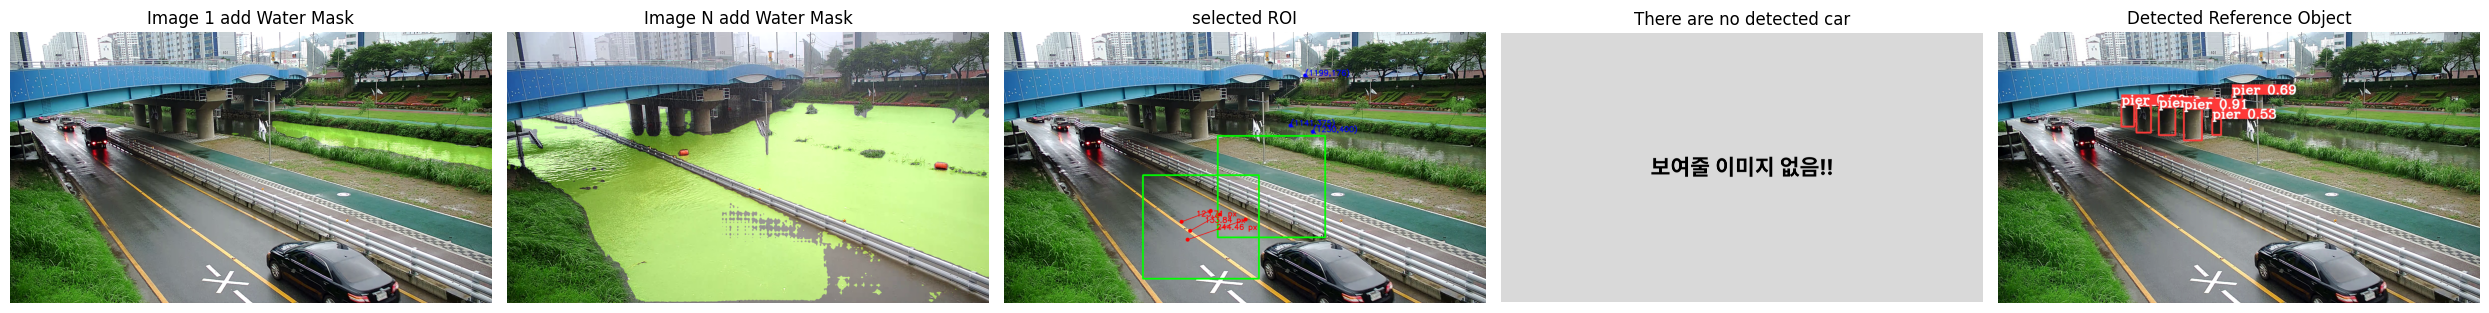

최종 침수 레벨: 3
침수 속도 추정 결과: 0.065 cm/sec


In [37]:
img_1_add_mask = cv2.cvtColor(mask_add(img_1_org, img_1_mask, (0, 100, 55)), cv2.COLOR_BGR2RGB)
img_n_add_mask = cv2.cvtColor(mask_add(img_n_org, img_n_mask, (0, 100, 55)), cv2.COLOR_BGR2RGB)
img_1_copy2_show = cv2.cvtColor(img_1_copy2, cv2.COLOR_BGR2RGB)


fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes[0].imshow(img_1_add_mask)
axes[0].axis('off')
axes[0].set_title('Image 1 add Water Mask')

axes[1].imshow(img_n_add_mask)
axes[1].axis('off')
axes[1].set_title('Image N add Water Mask')

axes[2].imshow(img_1_copy2_show)
axes[2].axis('off')
axes[2].set_title('selected ROI')

if car_detected_img is not None and car_detected_img.size:
    axes[3].imshow(car_detected_img)
    axes[3].axis('off')
    axes[3].set_title('Detected Cars')
else:
    axes[3].imshow(error_image)
    axes[3].axis('off')
    axes[3].set_title('There are no detected car')


if obj_detected_img is not None and obj_detected_img.size > 0:
    axes[4].imshow(obj_detected_img)
    axes[4].axis('off')
    axes[4].set_title('Detected Reference Object')
else:
    axes[4].imshow(error_image)
    axes[4].axis('off')
    axes[4].set_title('탐지된 참조객체 없음')

plt.tight_layout()
plt.show()

print(f"최종 침수 레벨: {final_level}")
print(f"침수 속도 추정 결과: {np.round(flood_speed, 3)} cm/sec")

<p align="center">
<img src="image/level.png" width = 700 height = 250 alt=error></img>
</p>

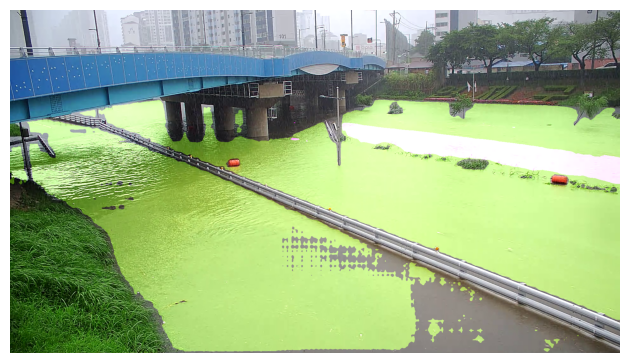

In [38]:
img_1_add_img_n_add_mask = mask_add(img_n_add_mask, img_1_mask, (255, 0, 255))

plt.imshow(img_1_add_img_n_add_mask)
plt.axis('off')
plt.tight_layout()
plt.show()

이전 결과물 (예시)

In [39]:
# OC_output = cv2.imread('example/OC_output.png', cv2.IMREAD_COLOR)
# SB_output = cv2.imread('example/SB_output.png', cv2.IMREAD_COLOR)
# SH_output = cv2.imread('example/SH_output.png', cv2.IMREAD_COLOR)
# UD_output = cv2.imread('example/UD_output.png', cv2.IMREAD_COLOR)
# YA_output = cv2.imread('example/YA_output.png', cv2.IMREAD_COLOR)

# # 이미지를 BGR에서 RGB로 변환
# OC_output = cv2.cvtColor(OC_output, cv2.COLOR_BGR2RGB)
# SB_output = cv2.cvtColor(SB_output, cv2.COLOR_BGR2RGB)
# SH_output = cv2.cvtColor(SH_output, cv2.COLOR_BGR2RGB)
# UD_output = cv2.cvtColor(UD_output, cv2.COLOR_BGR2RGB)
# YA_output = cv2.cvtColor(YA_output, cv2.COLOR_BGR2RGB)

# fig, axes = plt.subplots(5, 1, figsize=(100, 25))

# axes[0].imshow(OC_output)
# axes[0].axis('off')
# axes[0].set_title('OC_output: level 2')

# axes[1].imshow(SB_output)
# axes[1].axis('off')
# axes[1].set_title('SB_output: level 2')

# axes[2].imshow(SH_output)
# axes[2].axis('off')
# axes[2].set_title('SH_output: level 3')

# axes[3].imshow(UD_output)
# axes[3].axis('off')
# axes[3].set_title('UD_output: level 5')


# axes[4].imshow(YA_output)
# axes[4].axis('off')
# axes[4].set_title('YA_output: level 5')

# plt.tight_layout()
# plt.show()